# Why did I had to rescale the scales and switch their axes when building the transform parameters? 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import theano
import theano.tensor as T
import lasagne
from PIL import Image, ImageDraw
import IPython.display
import tracking.GaussianGenerator as gg
import tracking.VideoSequence as vs

/home/fmpaezri/.local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


## Define the network and create the function that receives actual data, just run once

In [3]:
#Input tensor
data = T.tensor4()
#Input layer definition
l_in = lasagne.layers.InputLayer((60, 3, 224,224))
#Location layer/variable
l_loc = T.matrix()
#Input shape instead of layer object
l_loc_shape = (None, 6)
#Transformer layer
l_trans = lasagne.layers.TransformerLayer(l_in, l_loc_shape, downsample_factor=1)
#Get output and correct shapes
transformed = l_trans.get_output_for((data.dimshuffle(0,3,2,1), l_loc)).dimshuffle(0,3,2,1)
#Function to be called
transform = theano.function([data, l_loc], transformed)

In [4]:
gen = gg.GaussianGenerator('/home/fmpaezri/datasets/mscoco/', \
        '/home/fmpaezri/repos/localization-agent/summaries/cocoSummaryCategAndSideGt100Smpls10000.pkl', \
        '/home/fmpaezri/repos/localization-agent/notebooks/gmmDenseAbsoluteNormalizedOOT.pkl', \
                           seqLength=60, imageSize=224, grayscale=False, parallel=False)

Loading summary from file /home/fmpaezri/repos/localization-agent/summaries/cocoSummaryCategAndSideGt100Smpls10000.pkl


## Create some data and visualize it, iterate

Frame batch shape: (1, 60, 224, 224, 3)


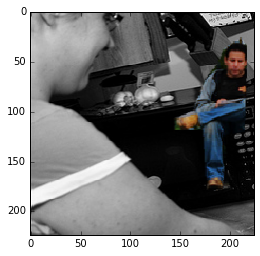

In [7]:
frames, labels, flow = gen.getBatch(1, 0, 60)
print 'Frame batch shape:', frames.shape
imshow(frames[0][0].astype(uint8))

In [8]:
originalPath = '/tmp/original.mp4'
originalSequence = vs.VideoSequence((Image.fromarray(frame.astype(uint8)) for frame in frames[0]))
originalSequence.exportToVideo(30, originalPath)
IPython.display.HTML(vs.displayHTML(originalPath))

## Change coordinates to the ones expected by network, iterate

In [17]:
#Transform that maps from scene to camera
Acs = numpy.array([[0,2,-1],[2,0,-1],[0,0,1]])
#Separate point tuples and normalize them to 0-1
normBoxPoints = labels[0].reshape((labels[0].shape[0], labels[0].shape[-1]/2, 2)) / frames[0][0].shape[:2]
#Create ones for homogeneous coordinate padding
paddingOnes = numpy.ones((labels[0].shape[0], labels[0].shape[-1]/2, 1))
#Create homogeneous coordinates
normBoxPoints = numpy.concatenate([normBoxPoints, paddingOnes], axis=2).swapaxes(2,1)
#Transform points to camera coords
Pc = numpy.dot(Acs[numpy.newaxis, ...], normBoxPoints).swapaxes(1,2)[0]
print 'Transformed points shape:', Pc.shape
#Calculate box center in cam ref frame
Cc = (Pc[...,0]+Pc[...,1])[...,:-1]/2
print 'Centers shape', Cc.shape
#Calculate dimensions in scene ref frame
Ss = (Pc[...,1]-Pc[...,0])[...,:-1]/2
#Scale to cam ref frame
Sc = Ss#numpy.dot(Acs[:2,:2], Ss.T).T
print 'Scaling shape:', Sc.shape

Transformed points shape: (60, 3, 2)
Centers shape (60, 2)
Scaling shape: (60, 2)


## Calculate transform parameters, transform input and visualize, iterate

Transformed batch shape: (224, 224, 3)


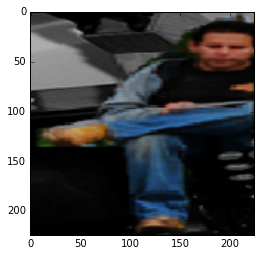

In [18]:
#Initial experiments
#params = numpy.reshape([Sc[0,1]/2, 0, Cc[0,0], 0, Sc[0,0]/2, Cc[0,1]]*frames.shape[1], (-1, 6))
#Parameter definition based on box reversing
params = numpy.stack([Sc[:,0], numpy.zeros((frames.shape[1],)), Cc[:,0], numpy.zeros((frames.shape[1],)), Sc[:,1], Cc[:,1]]).T
#Apply transform
transFrames = transform(frames[0], params)
print 'Transformed batch shape:', transFrames[0].shape
imshow(transFrames[0].astype(uint8))

In [19]:
outputPath = '/tmp/output.mp4'
outputSequence = vs.VideoSequence((Image.fromarray(frame.astype(uint8)) for frame in transFrames))
outputSequence.exportToVideo(30, outputPath)
IPython.display.HTML(vs.displayHTML(outputPath))